In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

import coremltools

# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.keras.applications import MobileNetV3Large
from keras.layers import Dense, Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint



from tensorflow.keras import Model



scikit-learn version 1.2.2 is not supported. Minimum required version: 0.17. Maximum required version: 1.1.2. Disabling scikit-learn conversion API.


In [2]:
TRAIN_DIR = '70-dog-breeds/train'
TEST_DIR = '70-dog-breeds/test'

train_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    validation_split = 0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

In [3]:
# Split the data into three categories.
train_images = train_generator.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6390 images belonging to 70 classes.
Found 1556 images belonging to 70 classes.
Found 700 images belonging to 70 classes.


In [4]:
# Resize Layer
resize_and_rescale = keras.Sequential([
  preprocessing.Resizing(224,224),
  preprocessing.Rescaling(1./255),
])

# Setup data augmentation
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),                       
], name="data_augmentation")

In [5]:
# Load the pretained model
pretrained_model = MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

print(len(train_images))
print(len(val_images))

200
49


In [6]:
# Build model
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(512, activation='relu')(pretrained_model.output)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(70, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(0.0001),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [7]:
# Create checkpoint callback
checkpoint_path = "./Finish CNN-Model/Checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)


# Create callback to visualize data
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./Finish CNN-Model/Graph', 
                                             histogram_freq=1, write_graph=True, 
                                             write_images=True, embeddings_freq=1)

In [8]:
# Train the model
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        EarlyStopping(patience = 5),
        tb_callback,
        checkpoint_callback,
    ]
)

Epoch 1/50
200/200 [==============================] - 44s 209ms/step - loss: 3.2223 - accuracy: 0.2632 - val_loss: 1.5303 - val_accuracy: 0.7558
Epoch 2/50
200/200 [==============================] - 41s 207ms/step - loss: 1.3789 - accuracy: 0.6546 - val_loss: 0.6483 - val_accuracy: 0.8445
Epoch 3/50
200/200 [==============================] - 40s 202ms/step - loss: 0.8140 - accuracy: 0.7806 - val_loss: 0.4829 - val_accuracy: 0.8663
Epoch 4/50
200/200 [==============================] - 42s 209ms/step - loss: 0.6191 - accuracy: 0.8227 - val_loss: 0.4238 - val_accuracy: 0.8747
Epoch 5/50
200/200 [==============================] - 42s 209ms/step - loss: 0.5008 - accuracy: 0.8543 - val_loss: 0.4002 - val_accuracy: 0.8734
Epoch 6/50
200/200 [==============================] - 41s 207ms/step - loss: 0.4342 - accuracy: 0.8710 - val_loss: 0.3822 - val_accuracy: 0.8850
Epoch 7/50
200/200 [==============================] - 44s 220ms/step - loss: 0.3972 - accuracy: 0.8836 - val_loss: 0.3641 - val_ac

In [9]:
# Show metrics
train_acc, train_loss = model.evaluate(train_images, verbose=0)
val_acc, val_loss = model.evaluate(val_images, verbose=0)
test_acc, test_loss = model.evaluate(test_images, verbose=0)
print("    Train Loss: {:.5f}".format(train_acc))
print("Train Accuracy: {:.2f}%".format(train_loss * 100))
print("    Valid Loss: {:.5f}".format(val_acc))
print("Valid Accuracy: {:.2f}%".format(val_loss * 100))
print("    Test Loss: {:.5f}".format(test_acc))
print("Test Accuracy: {:.2f}%".format(test_loss * 100))

    Train Loss: 0.02836
Train Accuracy: 99.50%
    Valid Loss: 0.34747
Valid Accuracy: 90.75%
    Test Loss: 0.09940
Test Accuracy: 96.29%


In [10]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [11]:
# Create a HDF5 file 'my_model_mobilenet_v3.h5'
from keras.models import load_model

model.save('./Finish CNN-Model/my_model_mobilenet_v3.h5')  

In [12]:
# Create labels with dog breeds for model
output_labels = [name for name in list(train_images.class_indices)] 
n_classes = len(output_labels) # 70 classes
output_labels[9] = "Bernese Mountain Dog"
output_labels[18] = "Bullmastiff"
output_labels[31] = "Dalmatian"
output_labels[35] = "Norwegian Elkhound"
output_labels[37] = "German Shepherd"
output_labels[40] = "Great Pyrenees"
output_labels[45] = "Japanese Chin"
output_labels[52] = "Mexican Hairless"
output_labels[54] = "Pekingese"
output_labels[59] = "Rhodesian Ridgeback"
output_labels[63] = "Scottish Terrier"
output_labels[64] = "Chinese Shar-Pei"
output_labels[66] = "Shih Tzu"

print(output_labels)

['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless', 'American Spaniel', 'Basenji', 'Basset', 'Beagle', 'Bearded Collie', 'Bernese Mountain Dog', 'Bichon Frise', 'Blenheim', 'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi', 'Boston Terrier', 'Boxer', 'Bullmastiff', 'Bull Terrier', 'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow', 'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote', 'Dalmatian', 'Dhole', 'Dingo', 'Doberman', 'Norwegian Elkhound', 'French Bulldog', 'German Shepherd', 'Golden Retriever', 'Great Dane', 'Great Pyrenees', 'Greyhound', 'Groenendael', 'Irish Spaniel', 'Irish Wolfhound', 'Japanese Chin', 'Komondor', 'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese', 'Mexican Hairless', 'Newfoundland', 'Pekingese', 'Pit Bull', 'Pomeranian', 'Poodle', 'Pug', 'Rhodesian Ridgeback', 'Rottweiler', 'Saint Bernard', 'Schnauzer', 'Scottish Terrier', 'Chinese Shar-Pei', 'Shiba Inu', 'Shih Tzu', 'Siberian Husky', 'Vizsla', 'Yorkie']


In [13]:
# Convert to Core ML and save model
classifier_config = coremltools.ClassifierConfig(output_labels)

coreml_model_conf = coremltools.convert(model, convert_to="mlprogram", inputs=[coremltools.ImageType(shape=(1, 224, 224, 3), color_layout=coremltools.colorlayout.RGB)], classifier_config=classifier_config)

coreml_model_conf.save("./Finish CNN-Model/dog_breeds_classify_with_labels")


Running MIL backend_mlprogram pipeline: 100%|██████████| 10/10 [00:00<00:00, 764.64 passes/s]


### Examples of dog breed classification.

Created a dictionary for predicting test images with breed labels. As a result of classification, 3 most probable breeds are identified and presented along with corresponding confidence values in percentage format.

In [14]:
index = list(range(0, 70))
labels = dict(zip(index, output_labels))
labels

{0: 'Afghan',
 1: 'African Wild Dog',
 2: 'Airedale',
 3: 'American Hairless',
 4: 'American Spaniel',
 5: 'Basenji',
 6: 'Basset',
 7: 'Beagle',
 8: 'Bearded Collie',
 9: 'Bernese Mountain Dog',
 10: 'Bichon Frise',
 11: 'Blenheim',
 12: 'Bloodhound',
 13: 'Bluetick',
 14: 'Border Collie',
 15: 'Borzoi',
 16: 'Boston Terrier',
 17: 'Boxer',
 18: 'Bullmastiff',
 19: 'Bull Terrier',
 20: 'Bulldog',
 21: 'Cairn',
 22: 'Chihuahua',
 23: 'Chinese Crested',
 24: 'Chow',
 25: 'Clumber',
 26: 'Cockapoo',
 27: 'Cocker',
 28: 'Collie',
 29: 'Corgi',
 30: 'Coyote',
 31: 'Dalmatian',
 32: 'Dhole',
 33: 'Dingo',
 34: 'Doberman',
 35: 'Norwegian Elkhound',
 36: 'French Bulldog',
 37: 'German Shepherd',
 38: 'Golden Retriever',
 39: 'Great Dane',
 40: 'Great Pyrenees',
 41: 'Greyhound',
 42: 'Groenendael',
 43: 'Irish Spaniel',
 44: 'Irish Wolfhound',
 45: 'Japanese Chin',
 46: 'Komondor',
 47: 'Labradoodle',
 48: 'Labrador',
 49: 'Lhasa',
 50: 'Malinois',
 51: 'Maltese',
 52: 'Mexican Hairless',
 5

1/1 [==============================] - 0s 458ms/step
99.96% 	 Beagle
0.01% 	 Bluetick
0.01% 	 Basset


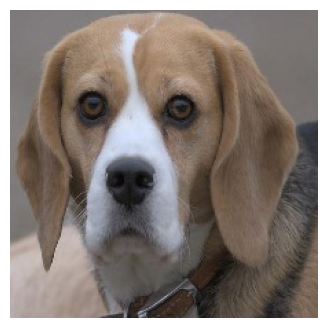

In [15]:
img = cv2.imread('./70-dog-breeds/test/Beagle/08.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(4, 4))
plt.imshow(img_rgb)
plt.axis('off')
test_img = preprocess_input(img_rgb)
probs = model.predict(np.expand_dims(test_img, axis=0))
for idx in probs.argsort()[0][::-1][:3]:
    print("{:.2f}%".format(probs[0][idx]*100), "\t", labels[idx])

1/1 [==============================] - 0s 40ms/step
47.97% 	 Basenji
36.19% 	 Dingo
10.32% 	 Shiba Inu


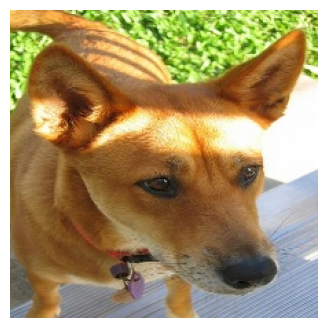

In [16]:
img = cv2.imread('./70-dog-breeds/test/Dingo/09.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(4, 4))
plt.imshow(img_rgb)
plt.axis('off')
test_img = preprocess_input(img_rgb)
probs = model.predict(np.expand_dims(test_img, axis=0))
for idx in probs.argsort()[0][::-1][:3]:
    print("{:.2f}%".format(probs[0][idx]*100), "\t", labels[idx])